## Patient SEEG avalanche analysis
1. <ins>Always run</ins>:
    1. Housekeeping - define and load relevant files
1. <ins>Starting point 1</ins>:
    1. Define parameters of parameter sweep and avalanche estimation
    1. Perform actual [parameter sweep](#Parameter-Sweep)
1. <ins>Starting point 2</ins>: 
    1. [Plot parameter sweep results](#Plot-parameter-sweep-results)
    1. [Recalculate avalanches with specific parameter set](#Calculate-avalanches-with-parameter-values-identified-from-sweep) identified from parameter sweep

In [36]:
# Housekeeping
#===============================================================================
import mne
import numpy as np
import os, re, sys, copy
import scipy
import scipy.stats as stat
import matplotlib.pyplot as plt
from importlib import reload
import powerlaw as pl
import pickle
import sklearn

import cde_seeg_functions as cs
import cde_seeg_importancesampling as ci
reload(cs)

# Define folder locations
#-------------------------------------------------------------------------------
F = {}
F['base']    = '/Users/roschkoenig/Dropbox/Research/1812 Critical Dynamics Epilepsy'
F['save']    = '/Users/roschkoenig/Dropbox/Research/1812 Critical Dynamics Epilepsy Data'
F['scripts'] = F['base'] +os.sep+ '07 - SEEG'
F['seeg']    = '/Volumes/GoogleDrive/My Drive/Research/1808 Intracranial Seizure Data'
Sublist      = cs.subject_specify(F)

In [2]:
# Manual definitions of various parameters
#===============================================================================
# Preprocessing
#-------------------------------------------------------------------------------
PP = {}
PP['Bands']          = [('broad', 1, 250),        # Frequency bands to be included in parameter sweep
                        ('delta', 1, 4), 
                        ('theta', 4, 8),
                        ('alpha', 8, 15),
                        ('beta', 15, 30), 
                        ('gamma', 30, 80), 
                        ('highg', 80,250)]

# band                 = 'highg'                   # Specify if only a single band is to be used
# thisb                = [item for item in PP['Bands'] if band in item]
# PP['Fbp']            = (thisb[0][1],thisb[0][2])      # Bandpass filter frequency band

# Binarisation
#-------------------------------------------------------------------------------
BN = {}
BN['separation_win'] = 0                         # Minimum enforced separation between peaks
BN['peak_height']    = 3                         # Minimum peak height (in z-score)
BN['edgewin']        = 1000                      # Section at the edge being ignored (to avoid filter artefact)

# Avalanche size estimation
#-------------------------------------------------------------------------------
AS = {} 
AS['dt']             = 3                         # delta t for detection of concurrent events (in samples)

# Parameter range used for parameter sweep
#-------------------------------------------------------------------------------
prange = np.linspace(2, 6, 12)                   # parameter ranges for sweep
trange = np.linspace(2, 21, 20).astype('int')    # parameter ranges for sweep 

### Parameter Sweep

In [6]:
reload(cs)

# Load and preprocess EEG segments
#===============================================================================
Subs = cs.avcalc(Sublist, PP['Bands'], BN, AS, prange, trange)

Frequency band 1 to 250Hz (broadband)
Working on subject 1 of 30
Processing: >>>>>>>>>>>

KeyboardInterrupt: 

In [7]:
# Save sweep results
#===============================================================================
if False:                  # <- change this if you actually to save the results
    Sweeps = []
    for s in Sub: Sweeps.append(s['Sweep'])
    with open(F['save']+os.sep+'Analysis'+os.sep+'SEEG_Avalanches'+os.sep+band[0]+'.pkl', 'wb') as handle:
        pickle.dump(Sweeps, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Plot parameter sweep results

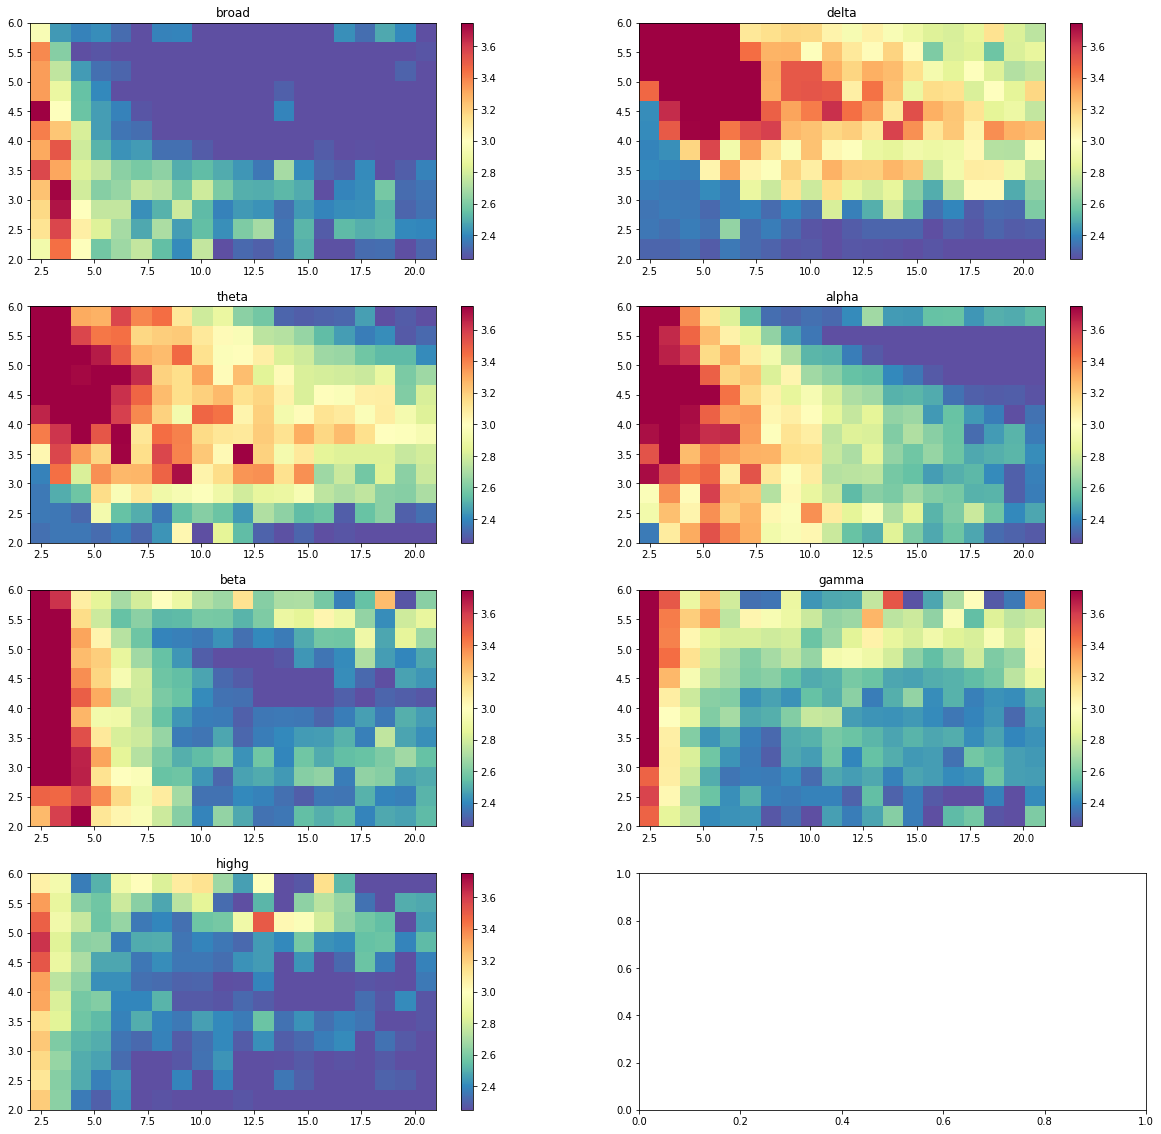

In [9]:
fig1, ax1 = plt.subplots(4,2,figsize = (20,20))
fig2, ax2 = plt.subplots(4,2,figsize = (20,20))

for band in range(len(PP['Bands'])):
    # Load picked file for the specific frequency band
    #--------------------------------------------------------------------------------------------
    print(PP['Bands'][band][0])
    Sweep = pickle.load(open(F['save']+os.sep+'Analysis'+os.sep+'SEEG_Avalanches'+os.sep+PP['Bands'][band][0]+'.pkl', 'rb'))

    # fit power laws to each parameter value
    #--------------------------------------------------------------------------------------------
    reload(cs)
    DM = []
    for s in range(len(Sweep)):
        dm = cs.plot_sweep(Sweep[s], doplot = False, cond='bl')
        DM = dm if DM == [] else np.dstack((DM, dm))

    # Plot mean map of the extracted values 
    #--------------------------------------------------------------------------------------------
    extentxy = (Sweep[s]['Time windows'][0], Sweep[s]['Time windows'][-1], 
                Sweep[s]['Peak thresholds'][0], Sweep[s]['Peak thresholds'][-1])
    dm  = np.nanmedian(DM,axis=2)
    img = ax1.flatten()[band].imshow(dm,extent=extentxy,cmap='Spectral_r', aspect='auto', vmin=2.25
                                    , vmax=3.75)
    fig1.colorbar(img, ax=ax.flatten()[band])
    ax1.flatten()[band].set_title(PP['Bands'][band][0])
    

## Plot individual examples
From the plot above, we can select values for the avalanche evaluation that produce a near critical distribution - e.g. `dt = 4` and `p = 4.5`

In [32]:
band                 = 6
AS['dt']             = 4 
BN['peak_height']    = 4

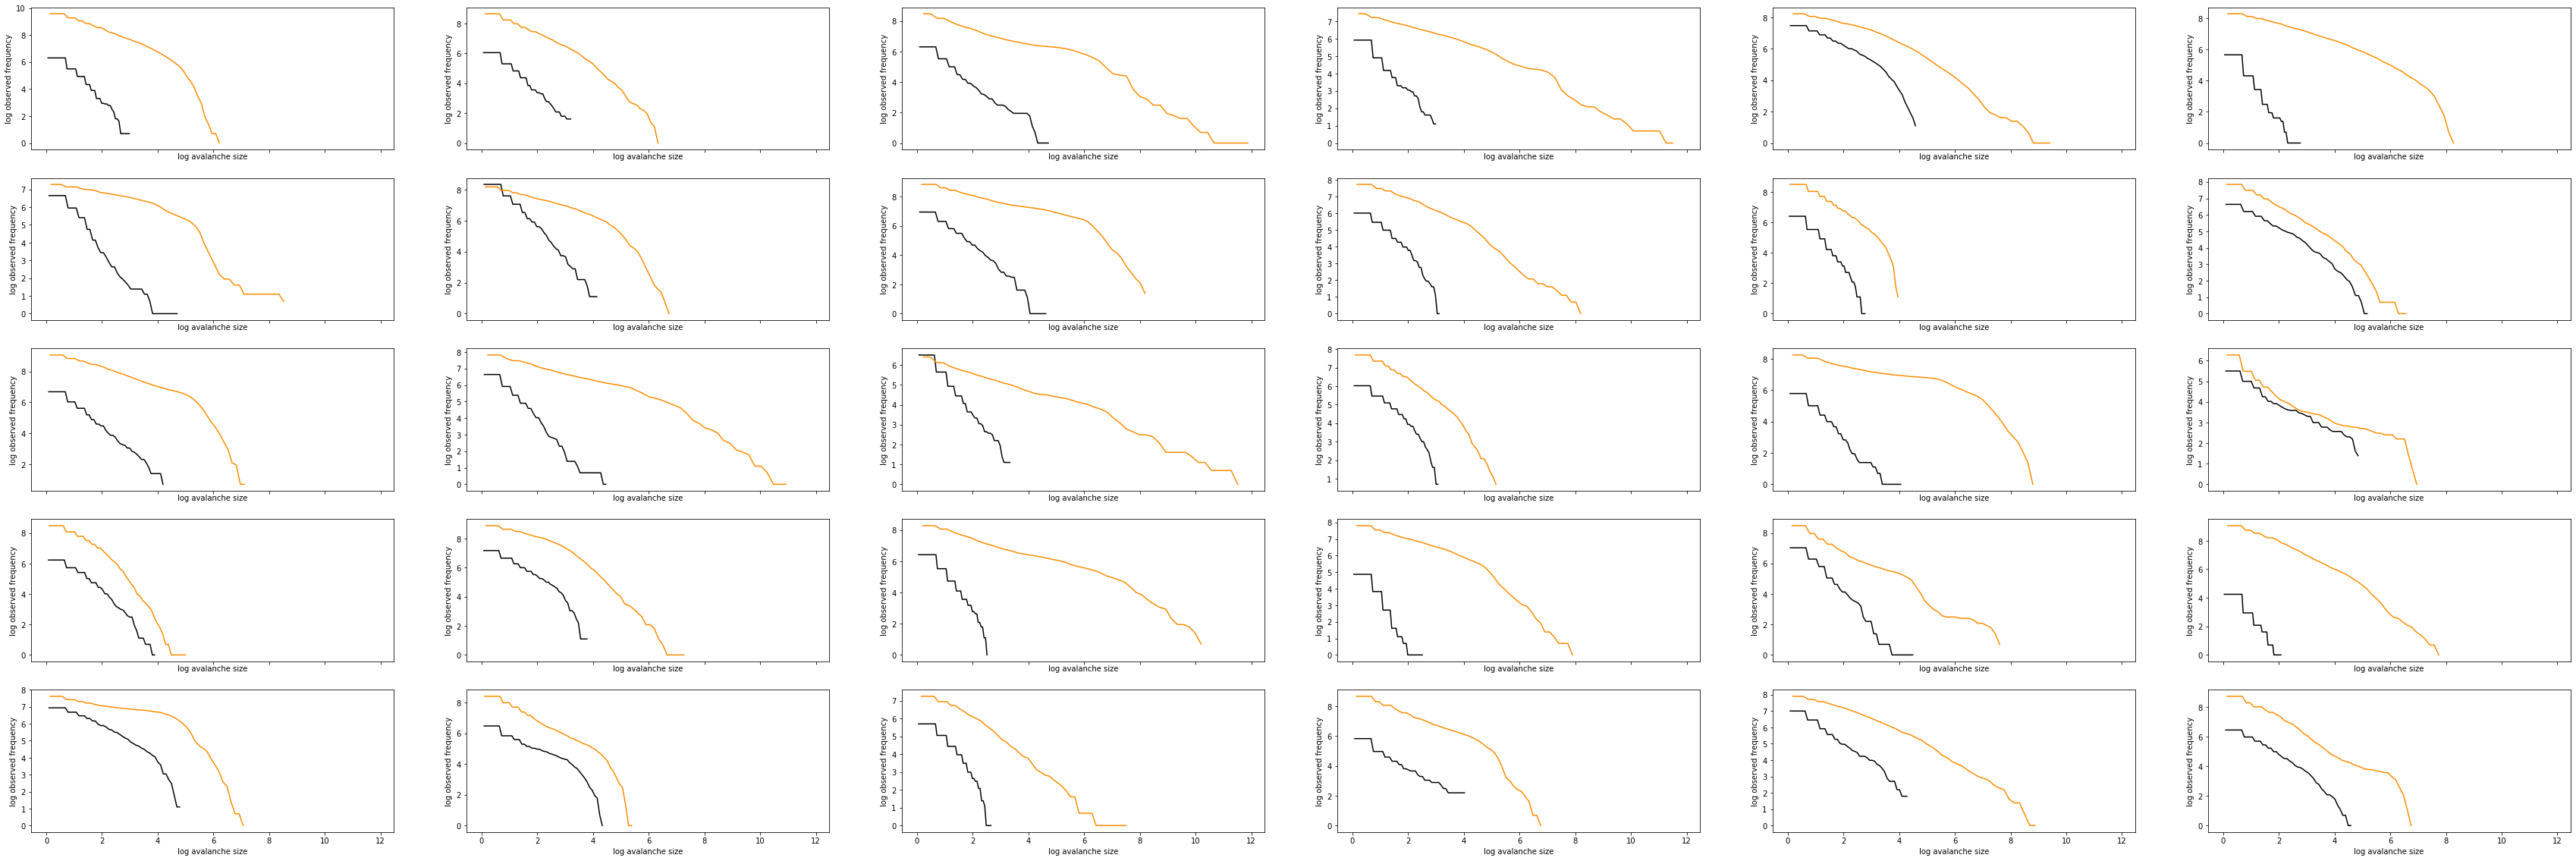

In [33]:
reload(cs)
tid  = np.argmin(abs(trange - AS['dt']))
pid  = np.argmin(abs(prange - BN['peak_height']))
f,ax = plt.subplots(5,6, figsize=(60,20), sharex = True)

Bl = []
Sz = []
for s in range(len(Sweep)):
    i  = (np.floor(s/6).astype('int'), np.mod(s,6)-1)
    cs.plot_ccdf(Sweep[s]['Avalanches'][pid][tid][0], ax = ax[i], plottype='line', color = 'black')
    cs.plot_ccdf(Sweep[s]['Avalanches'][pid][tid][1], ax = ax[i], plottype='line', color = 'darkorange')
    Bl.append(Sweep[s]['Avalanches'][pid][tid][0].T)
    Sz.append(Sweep[s]['Avalanches'][pid][tid][1].T)

    
f.savefig(F['save']+os.sep+'Analysis'+os.sep+'SEEG_Avalanches'+os.sep+PP['Bands'][band][0]+'.svg')

### Plot parameters of model fit 

In [ ]:
#Calculate entire trace PC-variance
#---------------------------------------------------------------------------------------------
data         = np.load(blnraw)
n_components = data.shape[1]
pca          = decomposition.PCA(n_components) #Define decomposition
fit          = pca.fit(data)
variance     = fit.explained_variance_ratio_

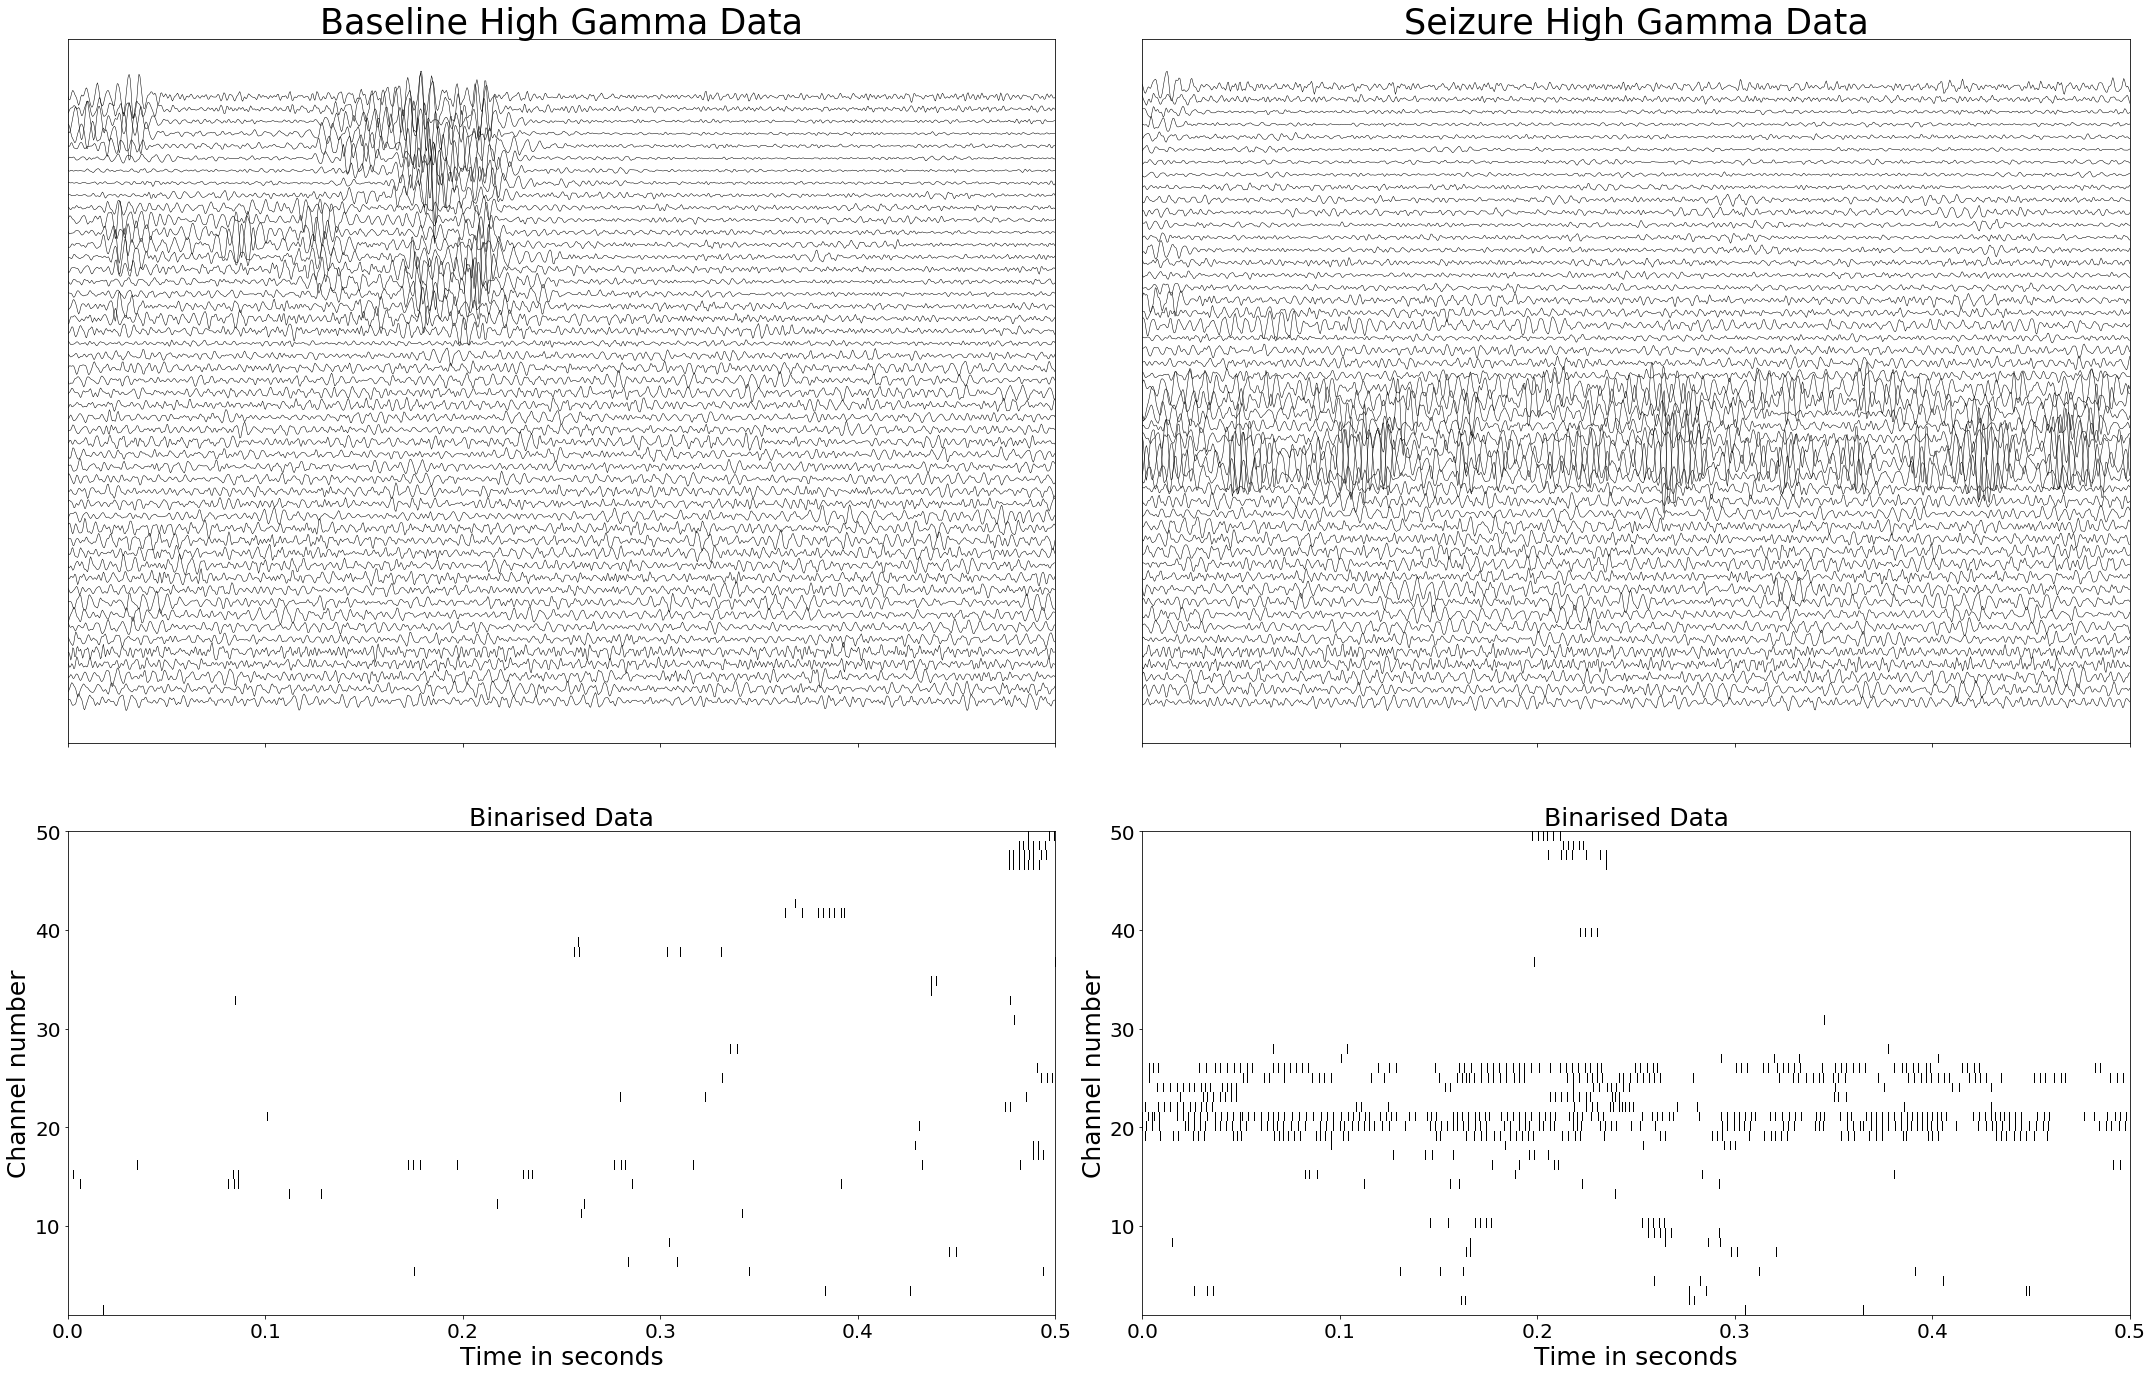

In [18]:
reload(cs)
cs.plot_ava([6])


# Functional form for power law
#---------------------------------------------------------------------------------------
def powerlaw(n,lam):
    zeta  = np.sum(1.0/np.arange(a,b+1)**lam)
    return(n**(-lam)/zeta)

# Functional form for lognormal
#---------------------------------------------------------------------------------------
def lognormal(n,mu,sig):
    return(1.0/n/np.sqrt(2*np.pi*sig**2)*np.exp(-(np.log(n)-mu)**2/(2*sig**2)))

# Power law log likelihood given the data
#---------------------------------------------------------------------------------------
def LogLikelihood(lam, sizes, M, a, b):
    # normalisation factor for all lambda draws - normalises a distribution to sum of 
    # probability = 1 (by summing across all possible values in density)
    
    zetamat = np.power.outer(1.0/np.arange(a,b+1),lam) # Matrix of normalisation constants for each lambda draw, at each size: each row =  size**-current lambda, for every size from max to min
    zeta    = np.sum(zetamat,0)                        # Norm vector - for each lambda draw - sum of norm constants for entire size max-min range at each lambda
    norm    = -M*np.log(zeta)                          # Contribution of zeta to the likelihood
    nprod   = -lam*np.sum(np.log(sizes))               # Loglikelihood calculation, given the data
    loglik  = nprod+norm                               # Normalised loglikelihood
    return(loglik)

# Lognormal log likelihood given the data
#---------------------------------------------------------------------------------------
def LogLikelihood_LN(mu, sig, sizes, M , a, b):
    
    T1     = -np.sum(np.log(sizes))
    T2_mat = np.subtract.outer(np.log(sizes),mu)**2
    T2     = -np.sum(T2_mat,0)/(2*sig**2)
    T0     = -M*np.log(np.sqrt(2*np.pi) * sig )
    loglik = T0 + T1 + T2
    return(loglik)

#IMPORTANCE SAMPLER - for power law - monte carlo sampling from two different distributions
#======================================================================================
def IS(npart, sizes, M, a, b):
    # Weights - loglikelihoods of your data for each lambda * (weight by) log probability of drawing each lambda sample from the prior, divided by log probability of drawing each lambda sample from the proposal
    # Likelihood of data weighted by prior expectation of lambda, and proposal expected lambda - cancel out the effect of the proposal
    # OUTPUT - posterior average exponent, log marginal likelihood, effective sample size = how good is the sampler
    
    lambda_sample    = np.random.uniform(0.1,5,npart)                      #randomly sample
    weights          = LogLikelihood(lambda_sample, sizes, M, a, b)+stat.norm.logpdf(lambda_sample,1,3)
                                     -stat.uniform.logpdf(lambda_sample,0.1,5)
    maxw             = np.max(weights)
    w2               = np.exp(weights-maxw)
    w2_sum           = np.sum(w2)
    ESS              = 1.0/(np.sum((w2/w2_sum)**2))
    mean_lambda      = np.dot(lambda_sample,w2)/w2_sum                     #average of the lambda value for the posterior distribution
    
    # marginal likelihood = empirical means of all the weights
    #-----------------------------------------------------------------------------------
    marglik = maxw + np.log(np.sum(np.exp(weights-maxw)))-np.log(npart)    #Take the exponent of logs to unlog, before summing/then divded by ncounts
    return([mean_lambda, marglik, LogLikelihood(lambda_sample, sizes, M , a, b), ESS])

#IMPORTANCE SAMPLER - for lognormal - monte carlo sampling from two different distributions
#======================================================================================
def IS_LN(npart, sizes, M, a, b):
    #OUTPUT - posterior average exponent, log marginal likelihood, effective sample size = how good is the sampler
    mu_sample        = np.random.uniform(-2.0,2.0,npart) #randomly sample mu
    sig_sample       = np.random.uniform(0.1,5.0,npart) #randomly sample sigma
    weights          = LogLikelihood_LN(mu_sample,sig_sample, sizes, M, a, b)
    maxw             = np.max(weights)
    w2               = np.exp(weights-maxw)
    w2_sum           = np.sum(w2)
    ESS              = 1.0/(np.sum((w2/w2_sum)**2))
    wmax_ID          = np.argmax(w2)
    mean_mu          = mu_sample[wmax_ID]
    mean_sig         = sig_sample[wmax_ID]
    
    #marginal likelihood = empirical means of all the weights
    marglik          = maxw + np.log(np.sum(np.exp(weights-maxw)))-np.log(npart)
    return([mean_mu,mean_sig, marglik,  LogLikelihood_LN(mu_sample, sig_sample, sizes, M, a, b), ESS])

#find entire posterior dsitr - posterior distribution - range of values
#-----------------------------------------------------------------------------------
def plot_samples(npart):
    lambda_sample  = np.random.uniform(0.1,5,npart)
    weights        = LogLikelihood(lambda_sample)
    maxw           = np.max(weights)
    w2             = np.exp(weights-maxw)
    plt.hist(lambda_sample,weights=w2,bins=np.linspace(2.5,2.8))
    plt.show()
    
def plotcomp(lam,mu,sig):
    x = np.linspace(a,b,40)
    plt.hist(sizes,40,log=True,density=True)
    plt.plot(x,powerlaw(x,lam))
    plt.plot(x,lognormal(x,mu,sig))
    plt.show()

/Users/roschkoenig/Dropbox/Research/1812 Critical Dynamics Epilepsy/07 - SEEG/cde_seeg_functions.py:189: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.log(avc_binned[1][1:]), np.log(avc_cdf), color=tc)


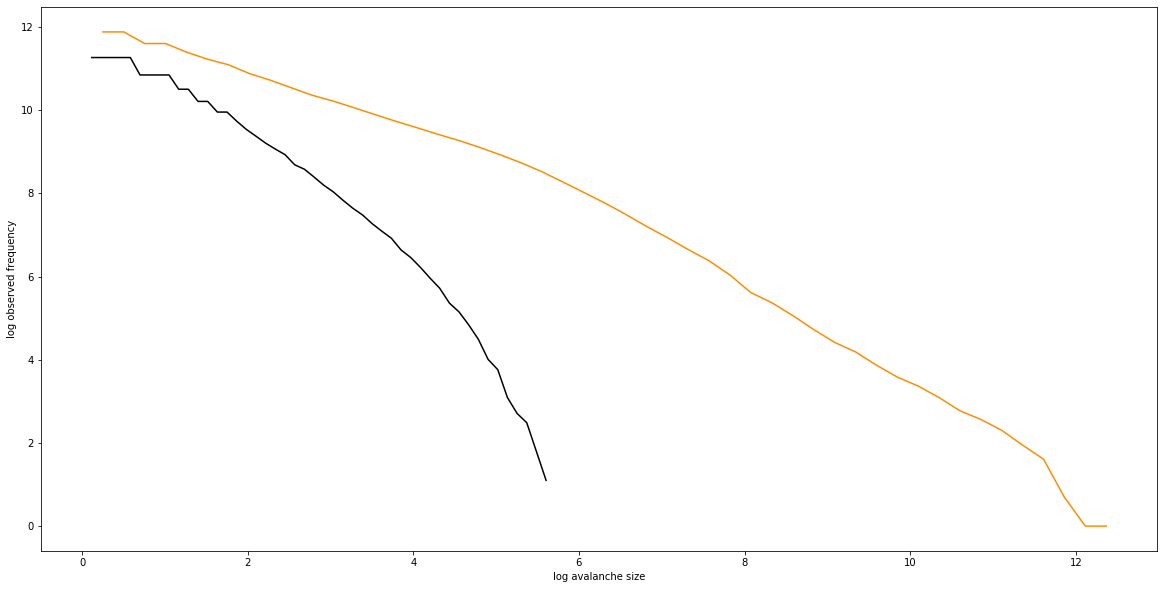

In [346]:
Bl = [j for sub in Bl for j in sub] 
Sz = [j for sub in Sz for j in sub]

f,ax = plt.subplots(1,1, figsize=(20,10))
cs.plot_ccdf(Bl, ax=ax, plottype='line', color = 'black')
cs.plot_ccdf(Sz, ax=ax, plottype='line', color = 'darkorange')

In [99]:
os.getcwd()

'/Users/roschkoenig/Dropbox/Research/1812 Critical Dynamics Epilepsy/07 - SEEG'

In [271]:
importlib.reload(cs)

for s in range(1):

    # Binarise and calculate cascade statistics 
    #-------------------------------------------------------------------------------
    Sub[s] = cs.subject_binarise(Sub[s], PP, BN)

/Users/roschkoenig/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':
/Users/roschkoenig/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


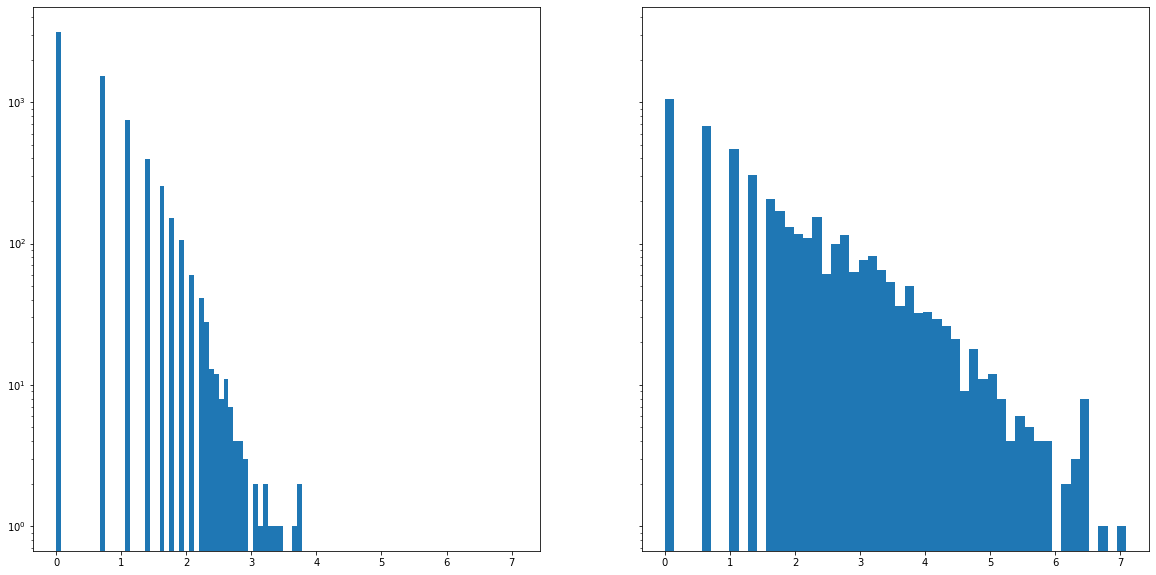

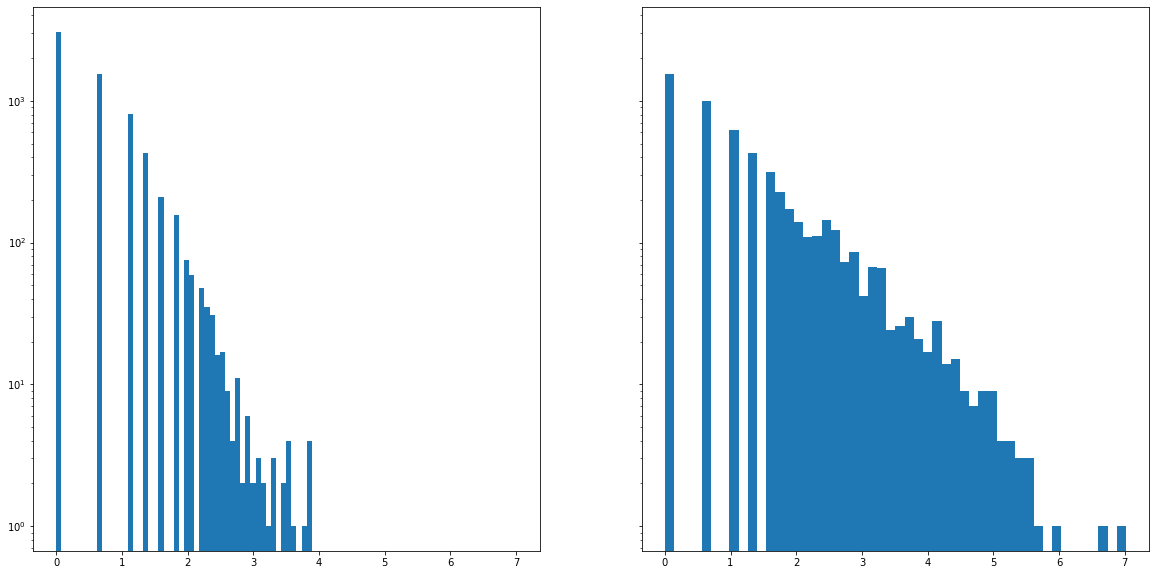

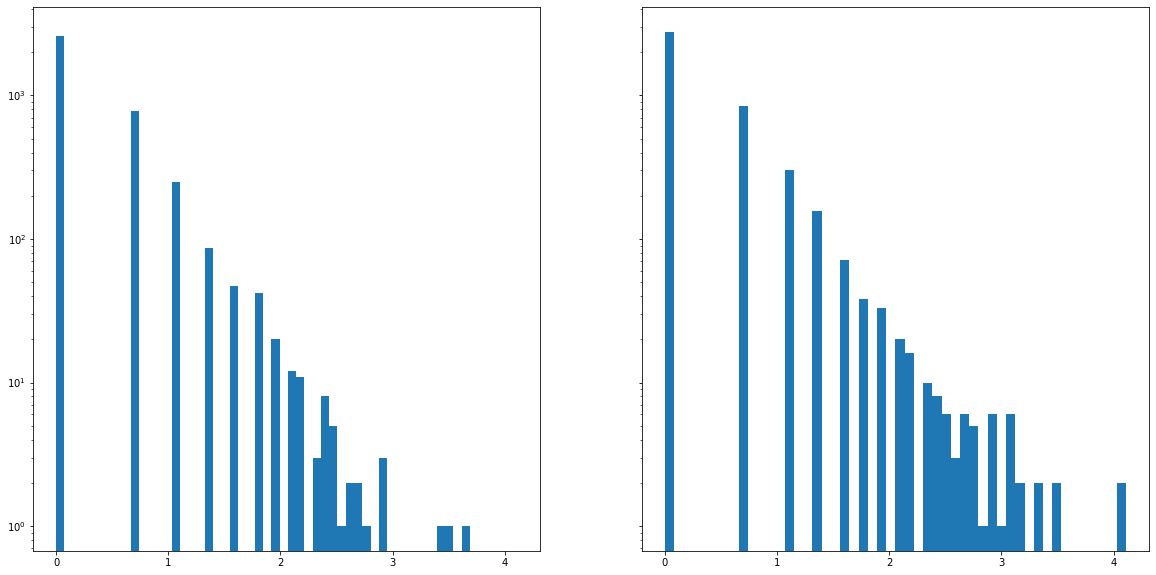

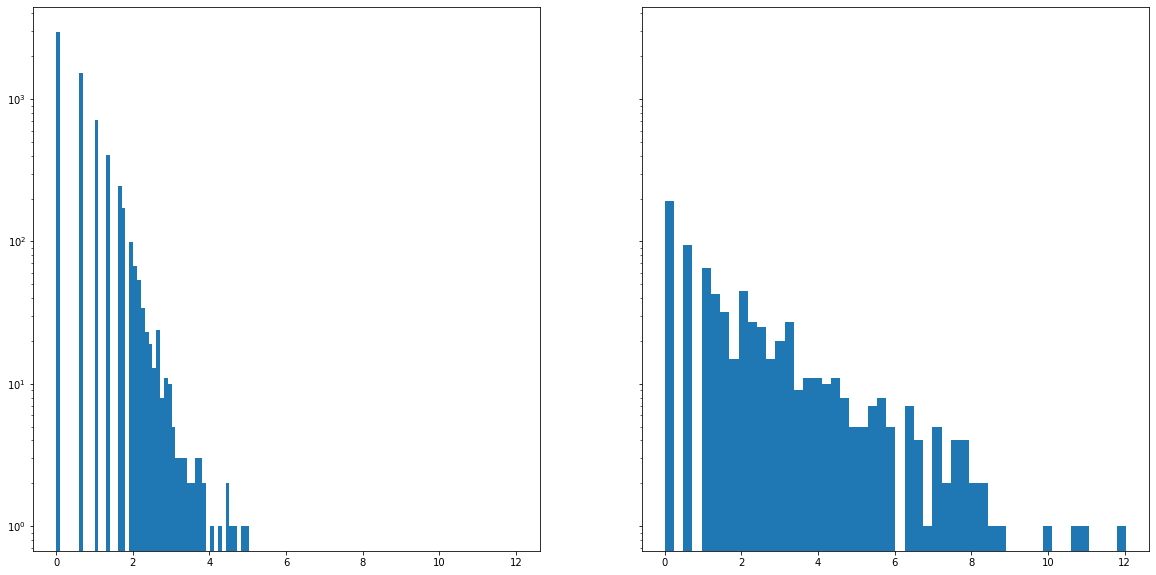

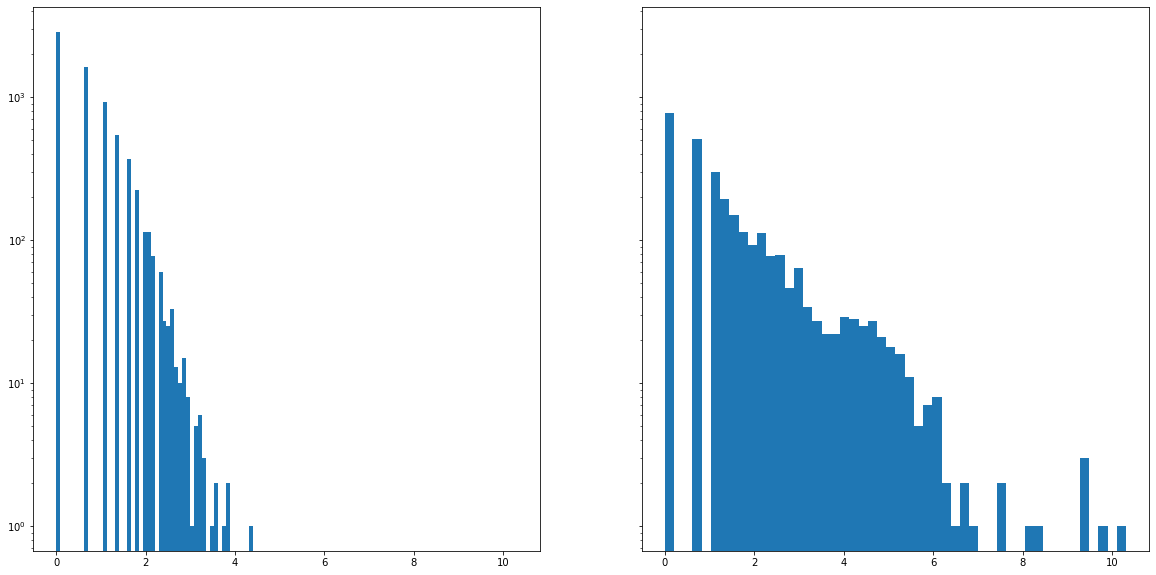

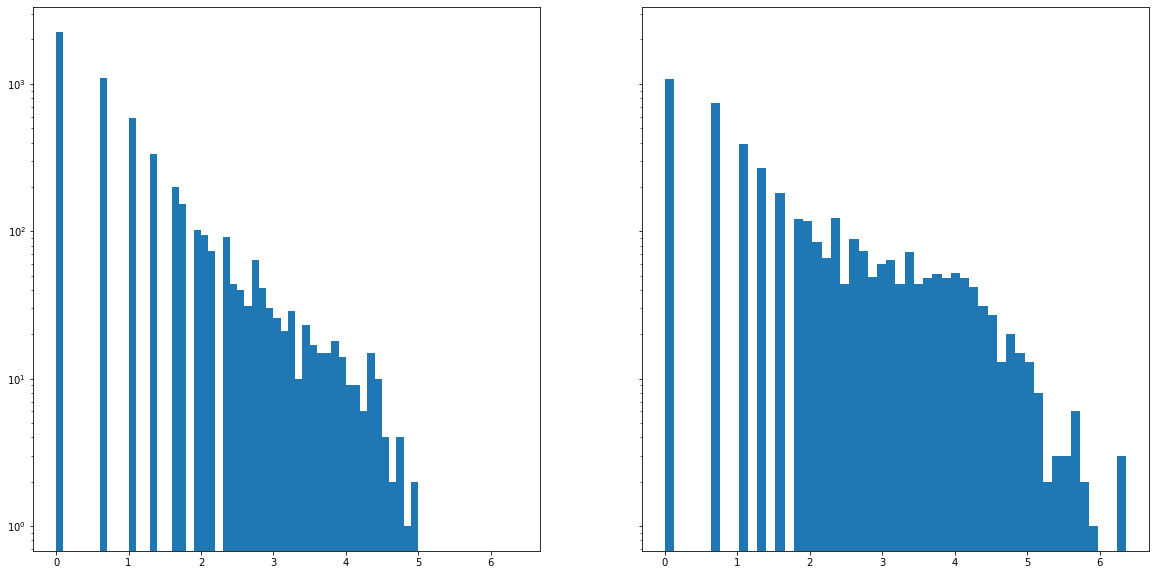

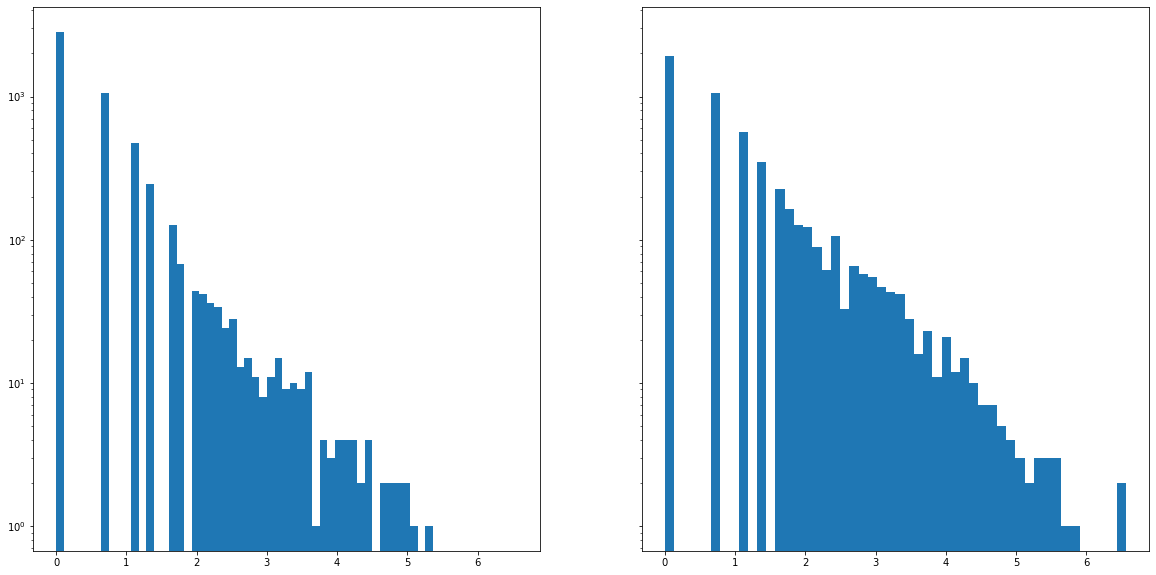

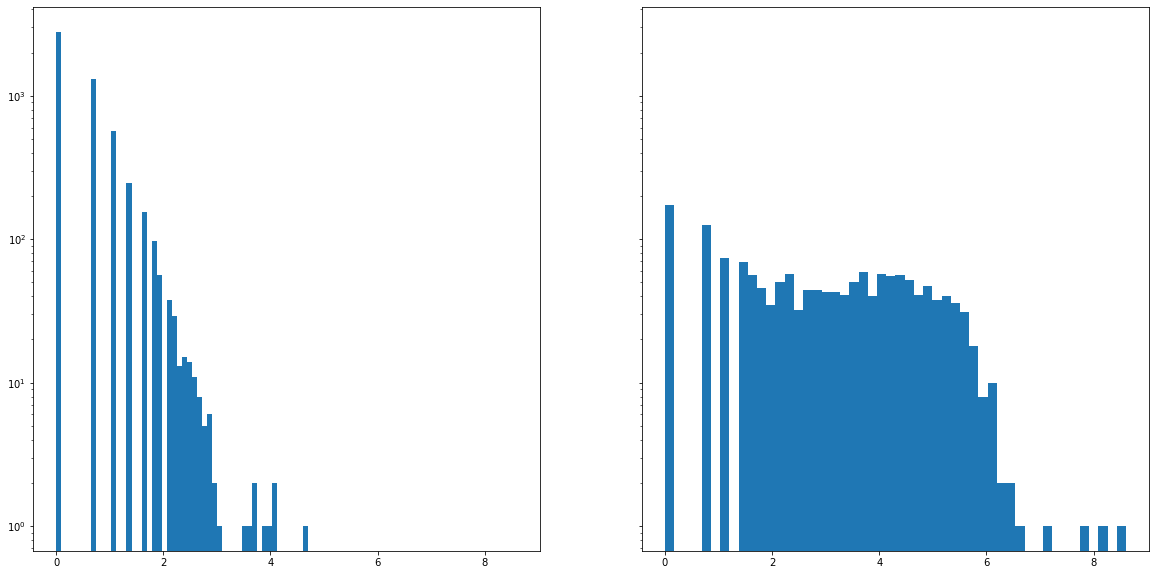

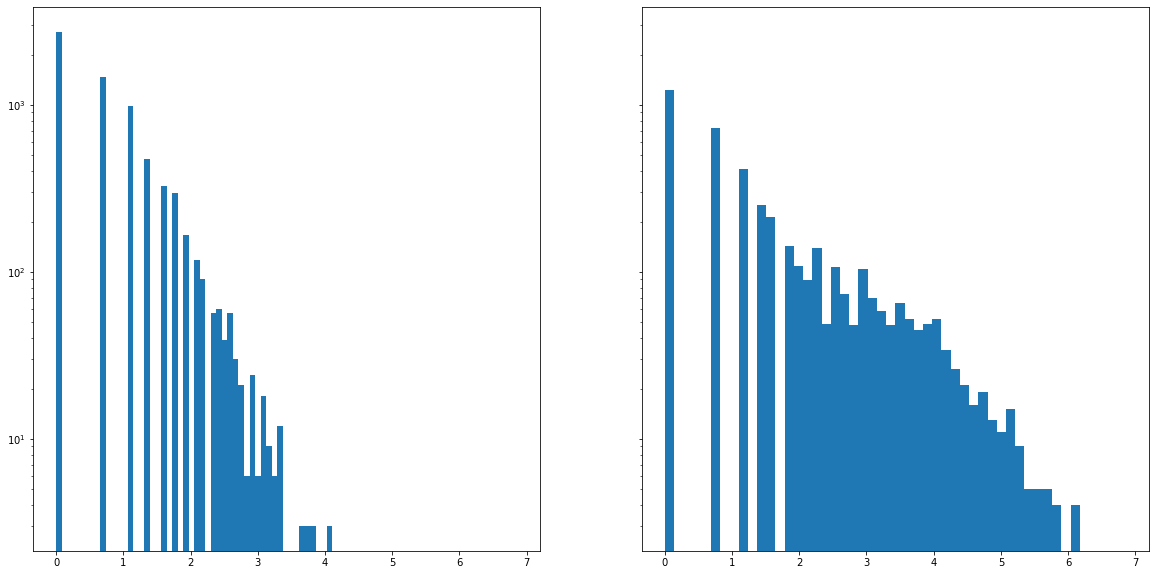

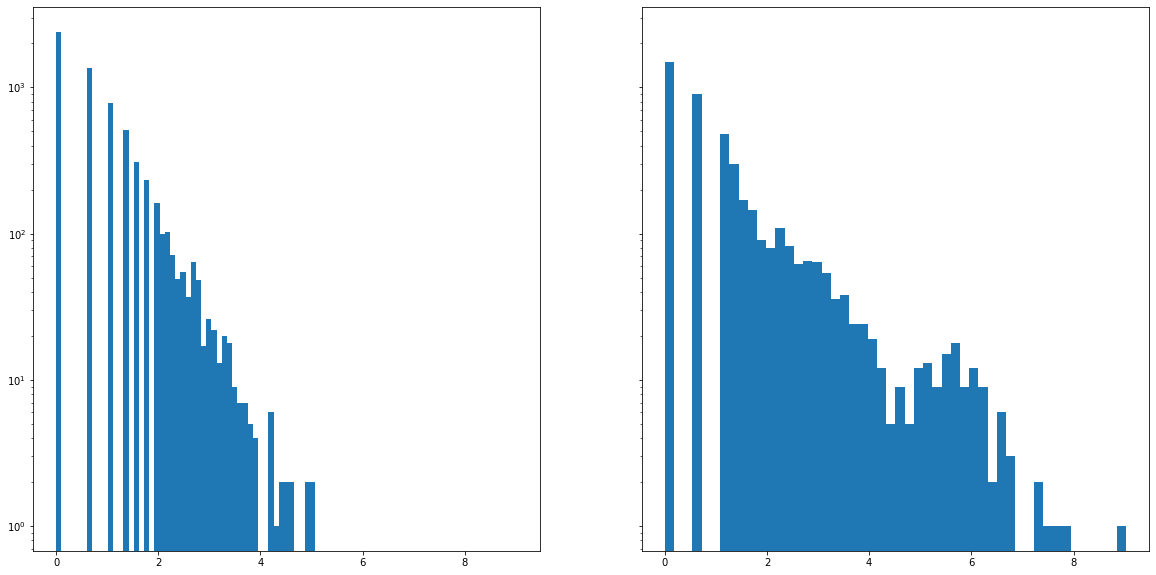

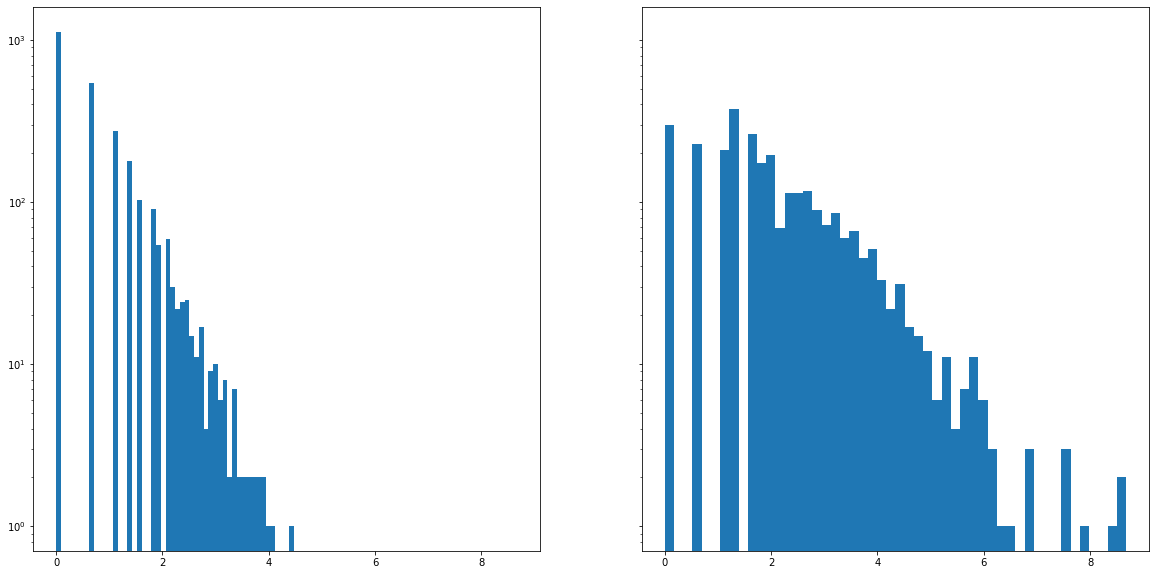

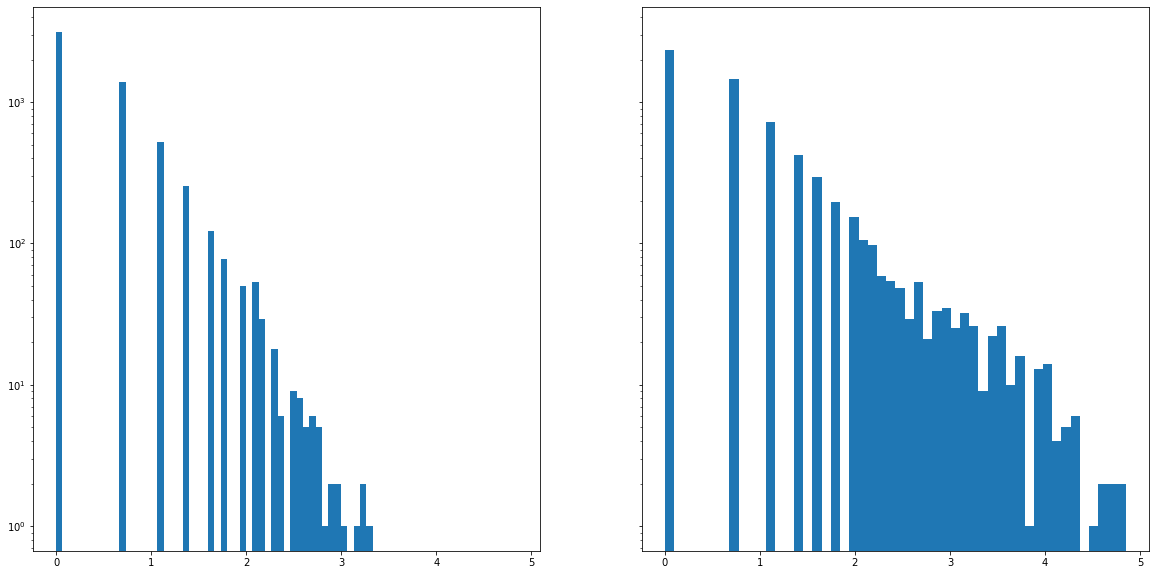

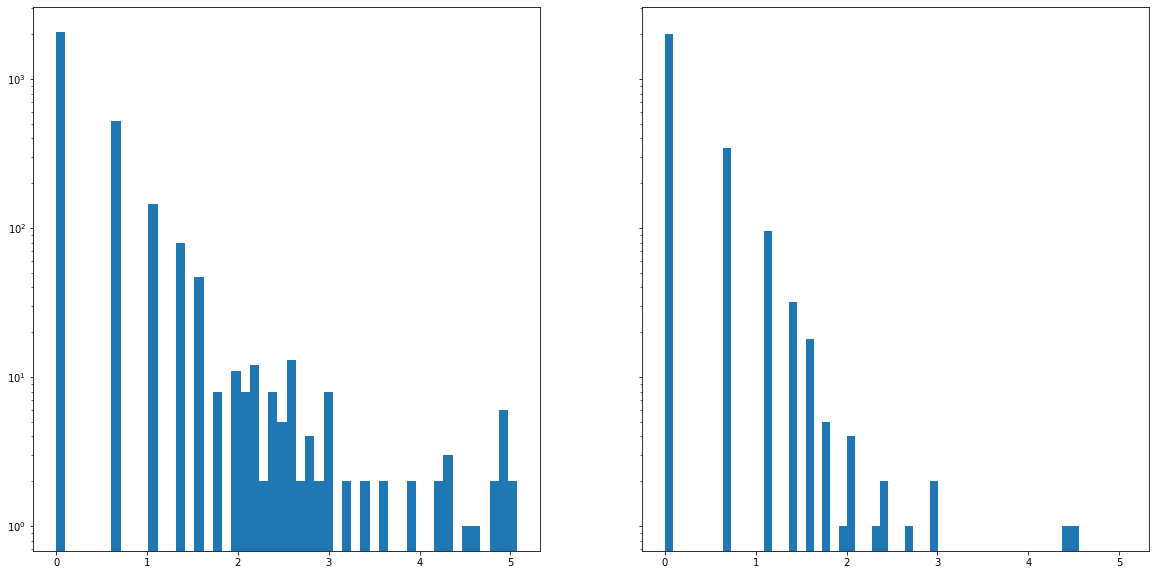

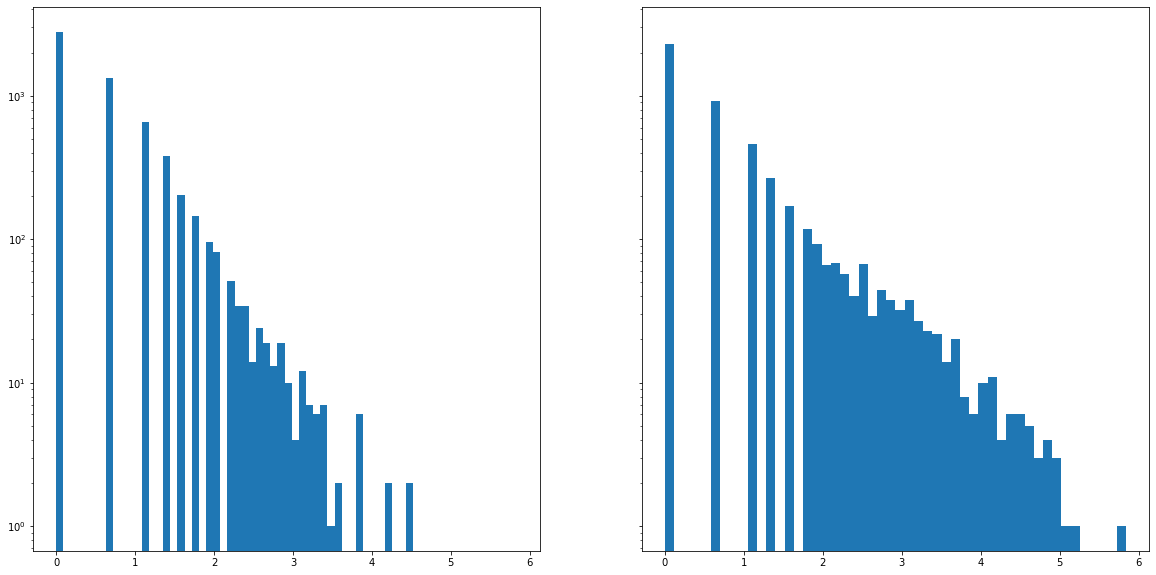

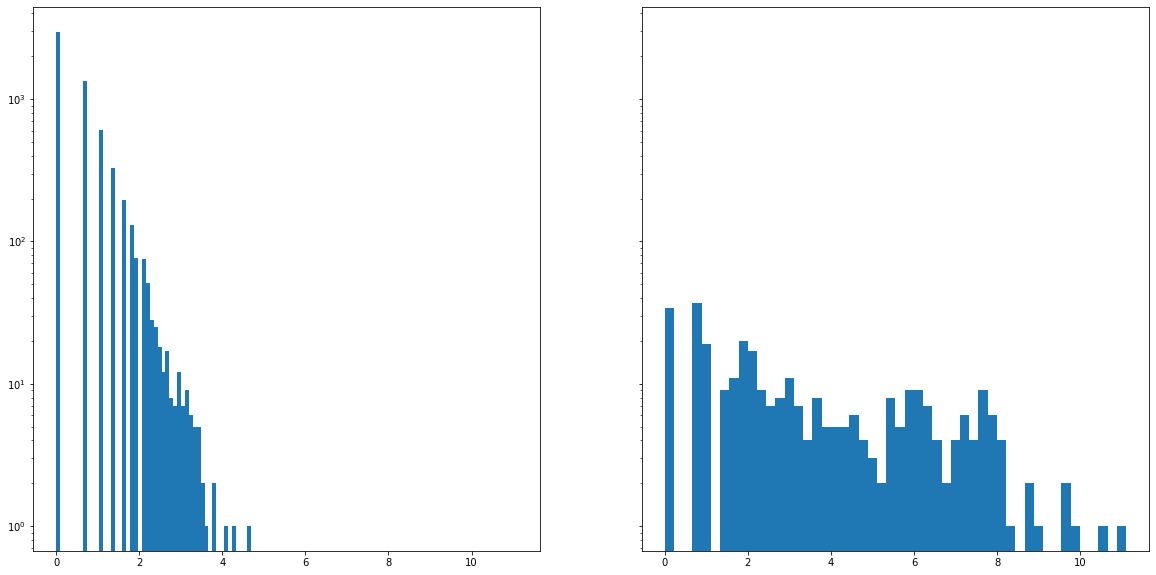

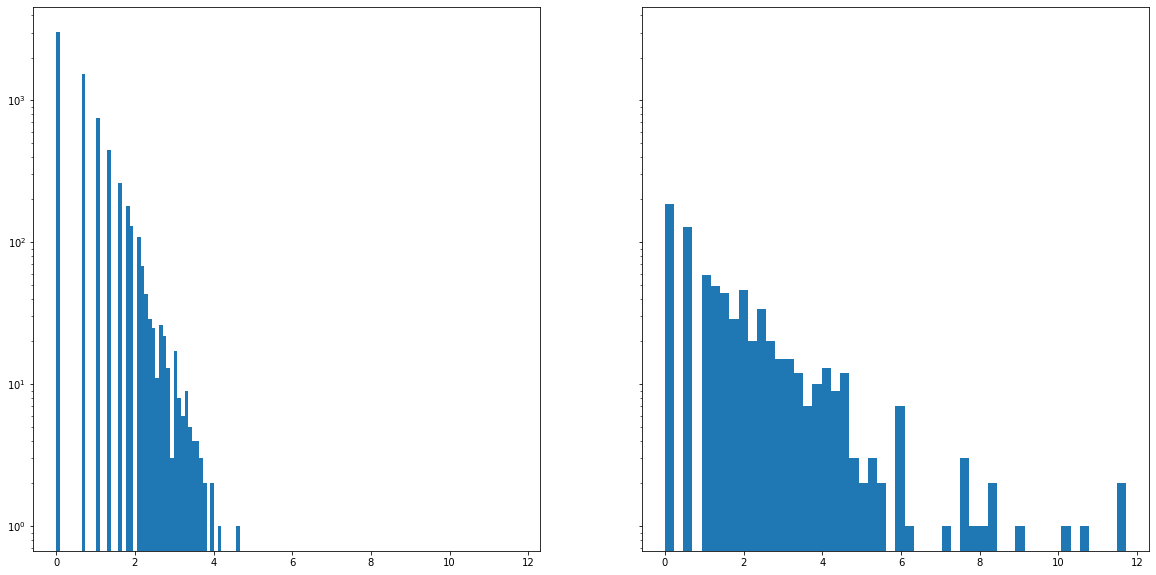

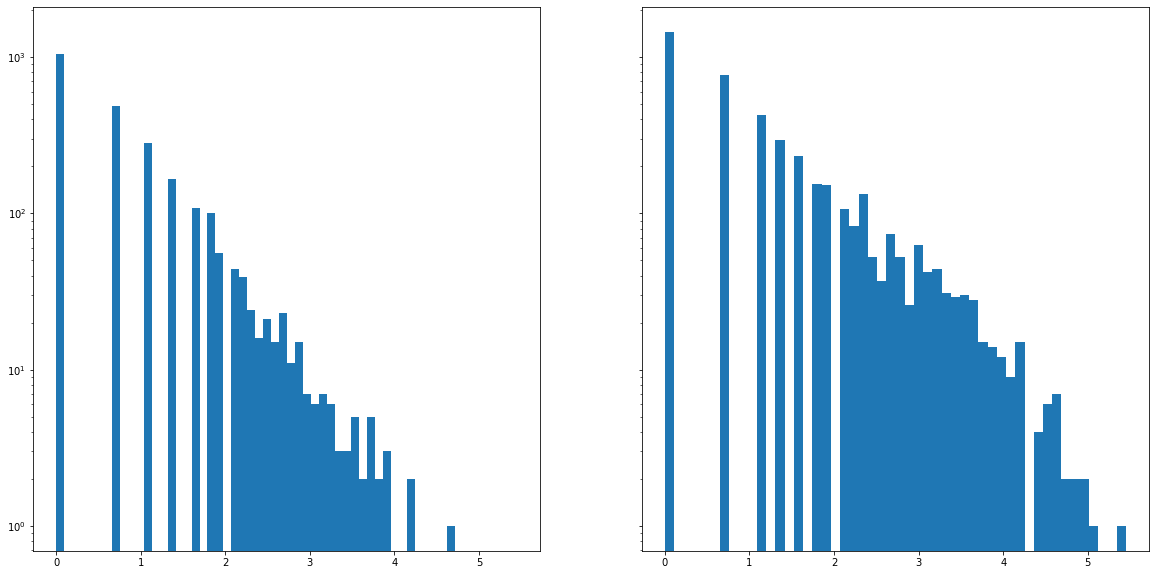

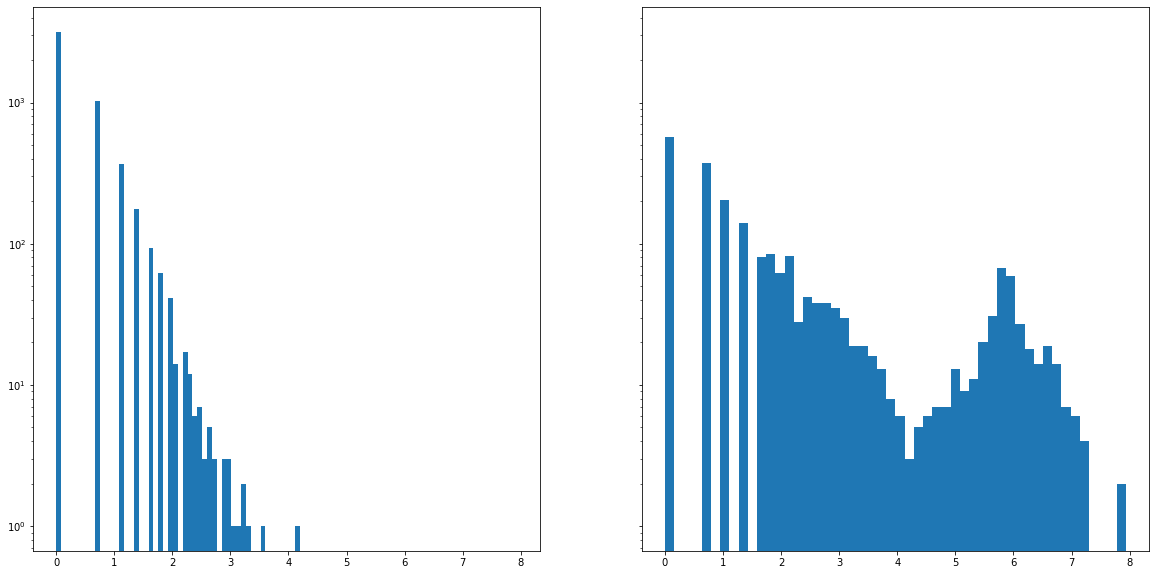

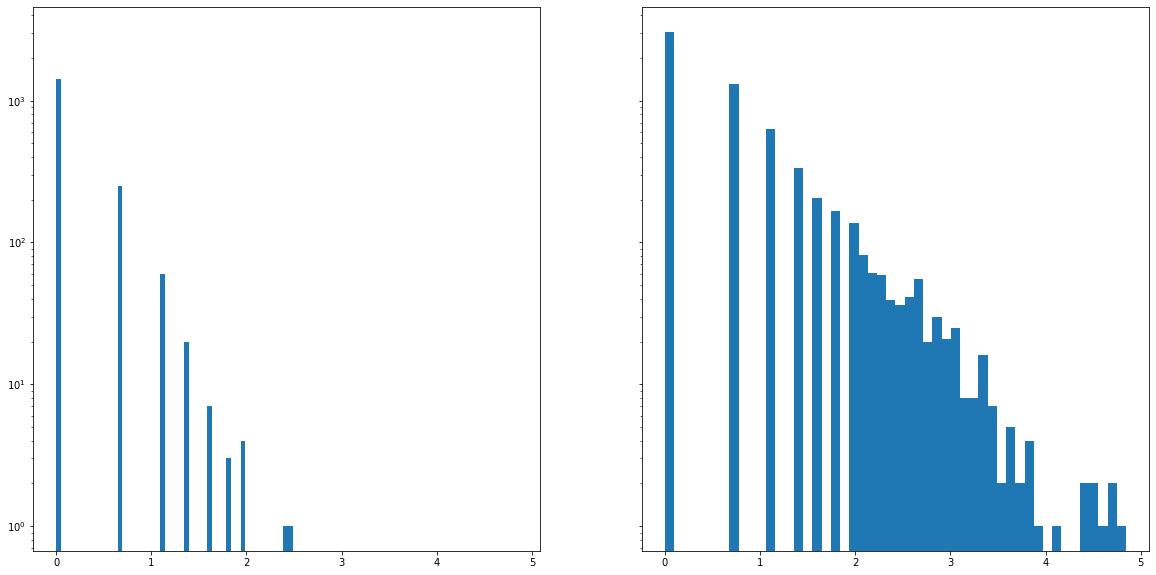

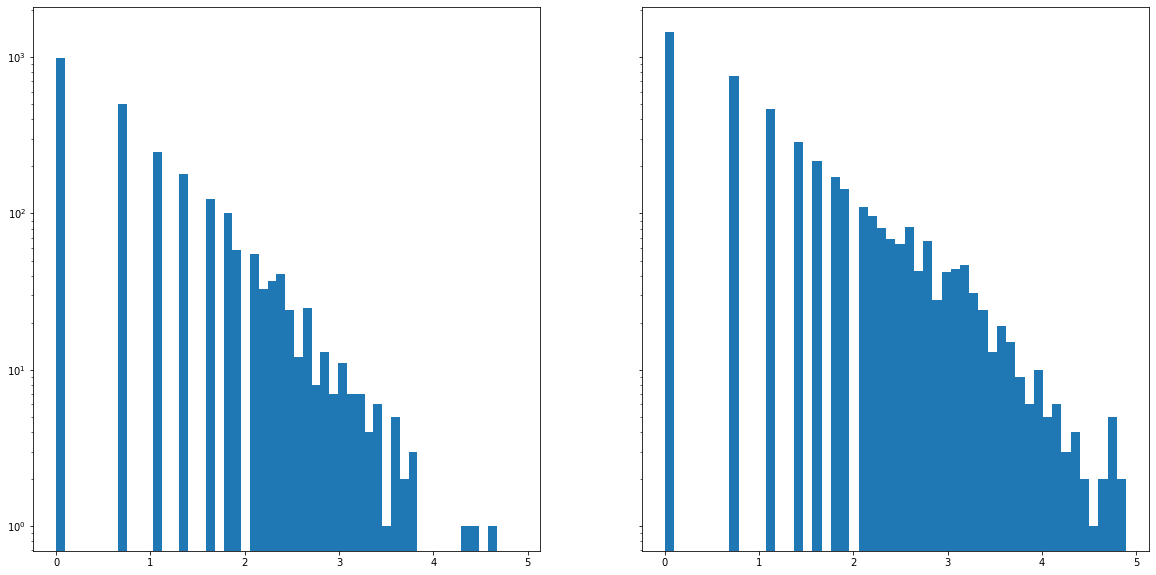

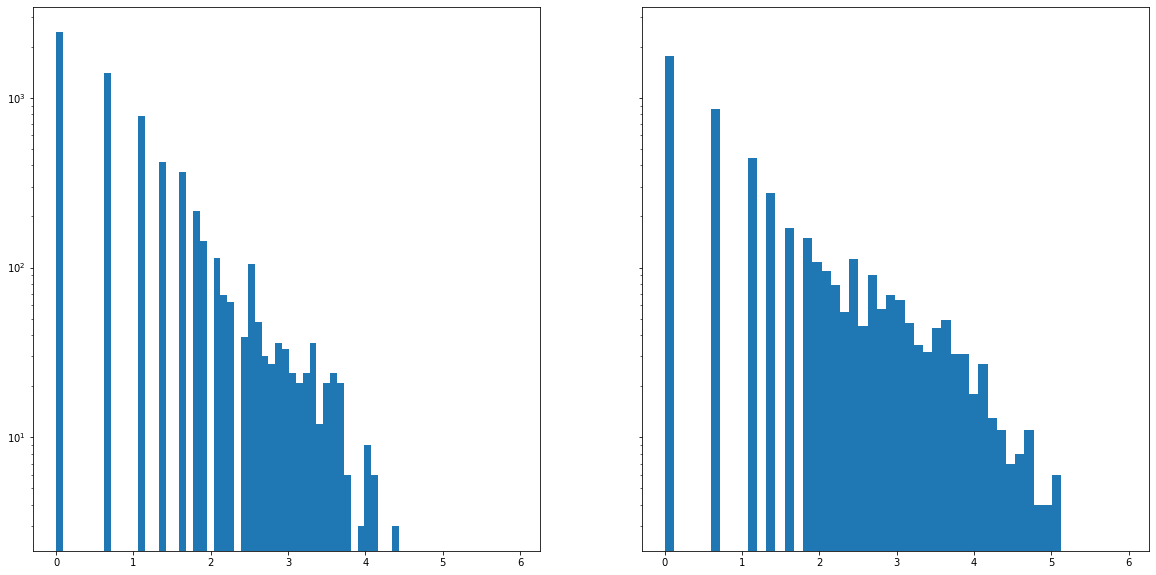

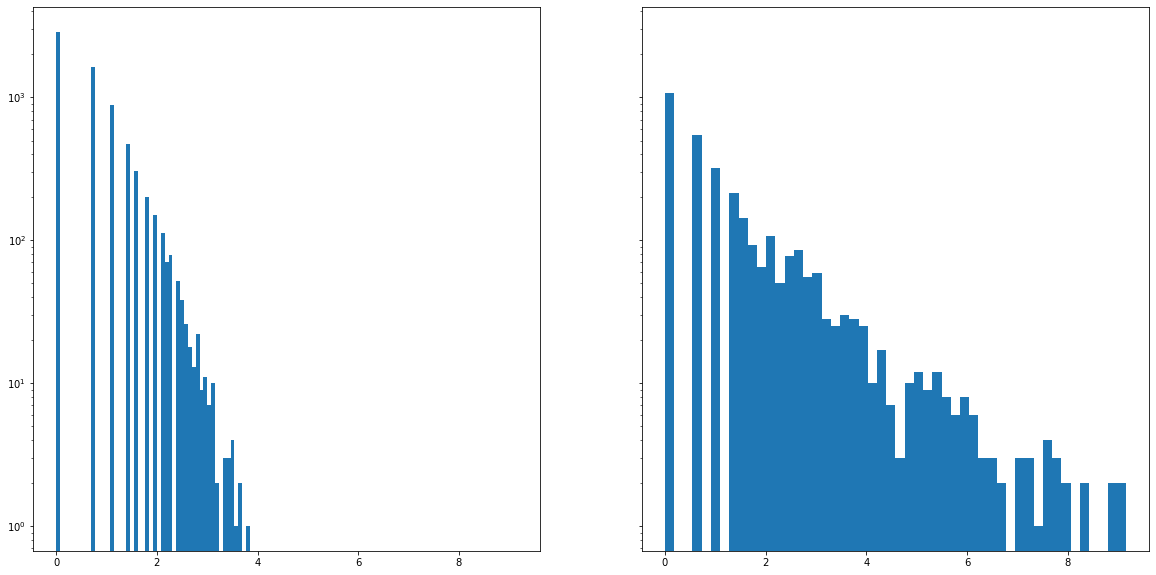

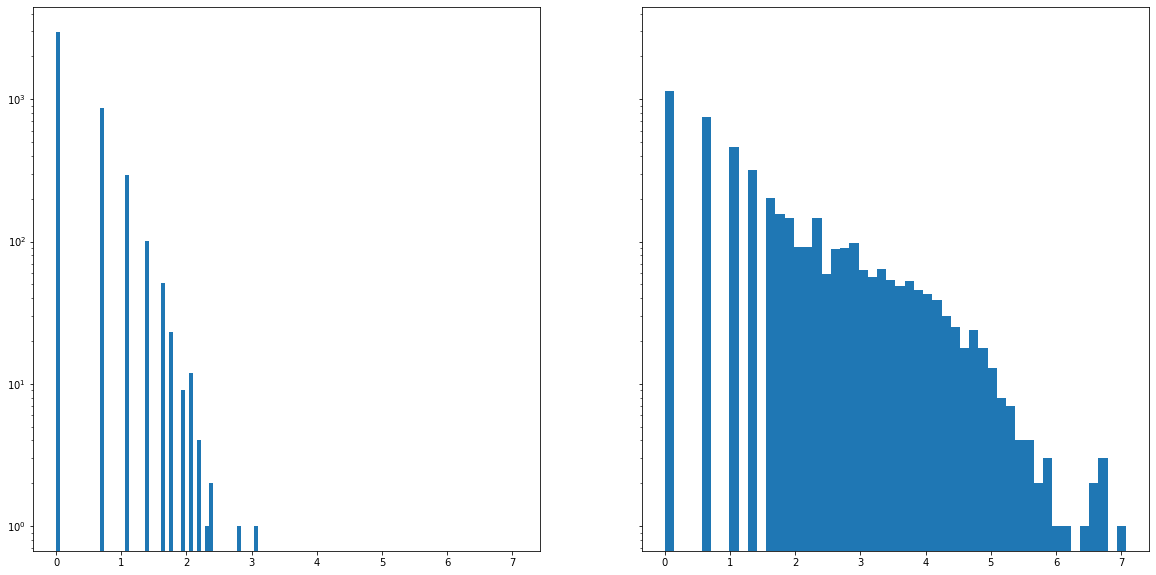

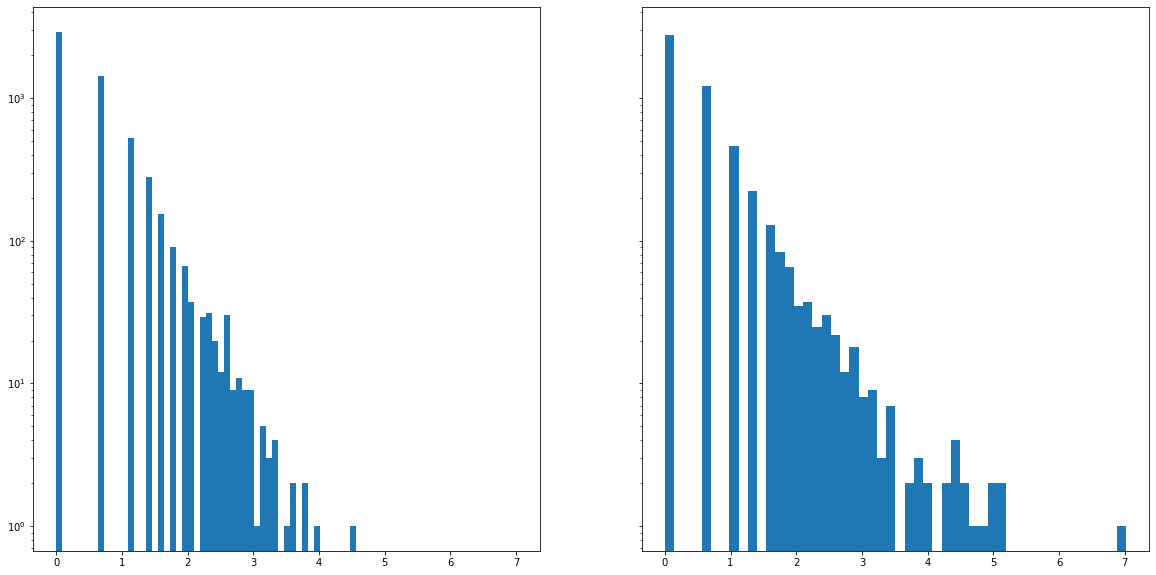

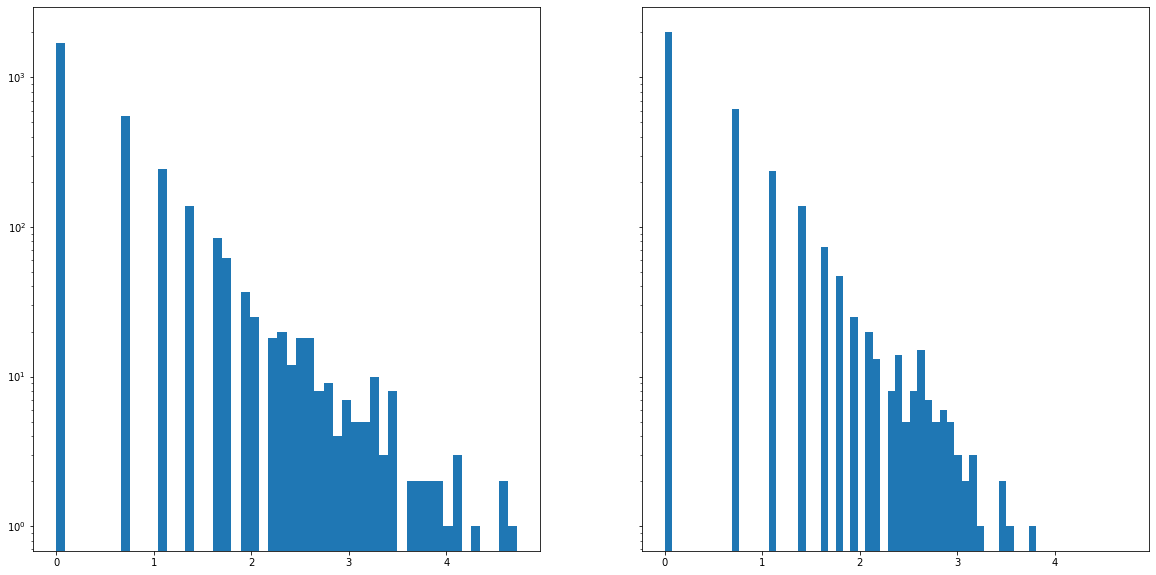

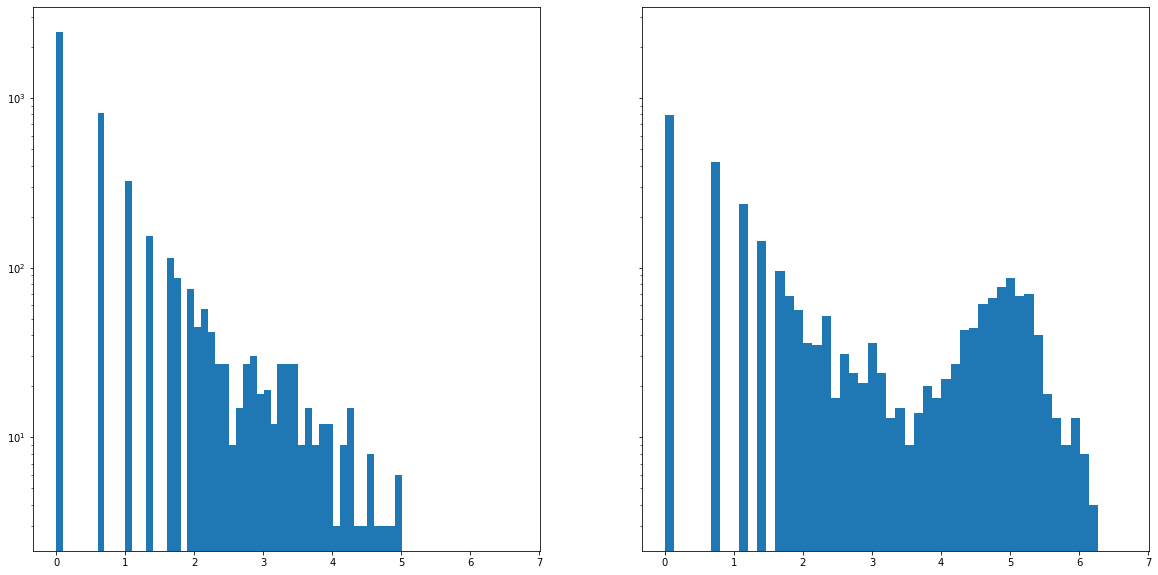

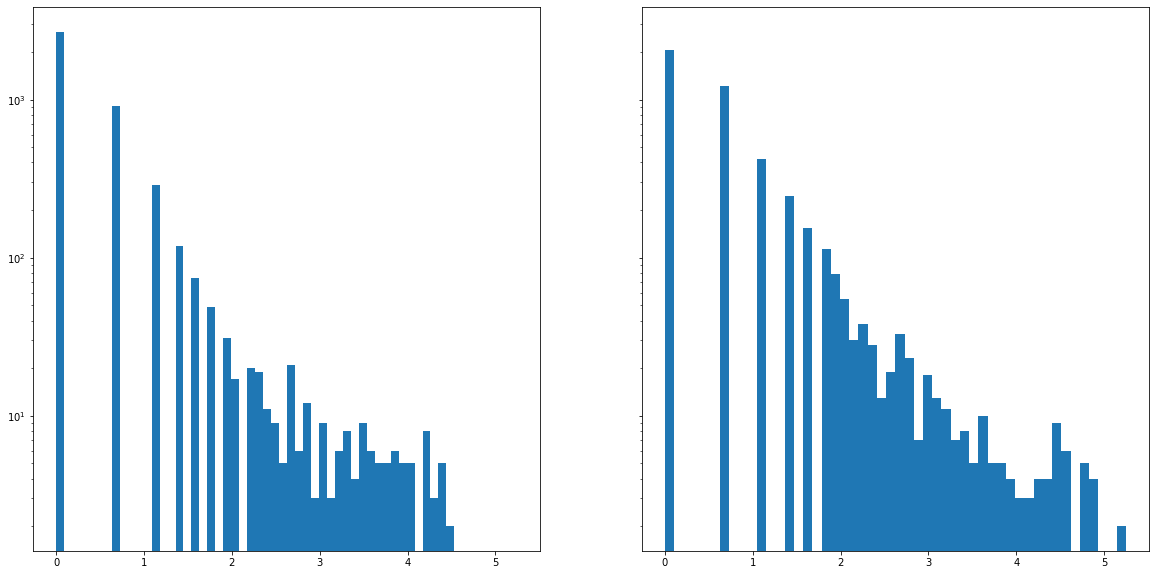

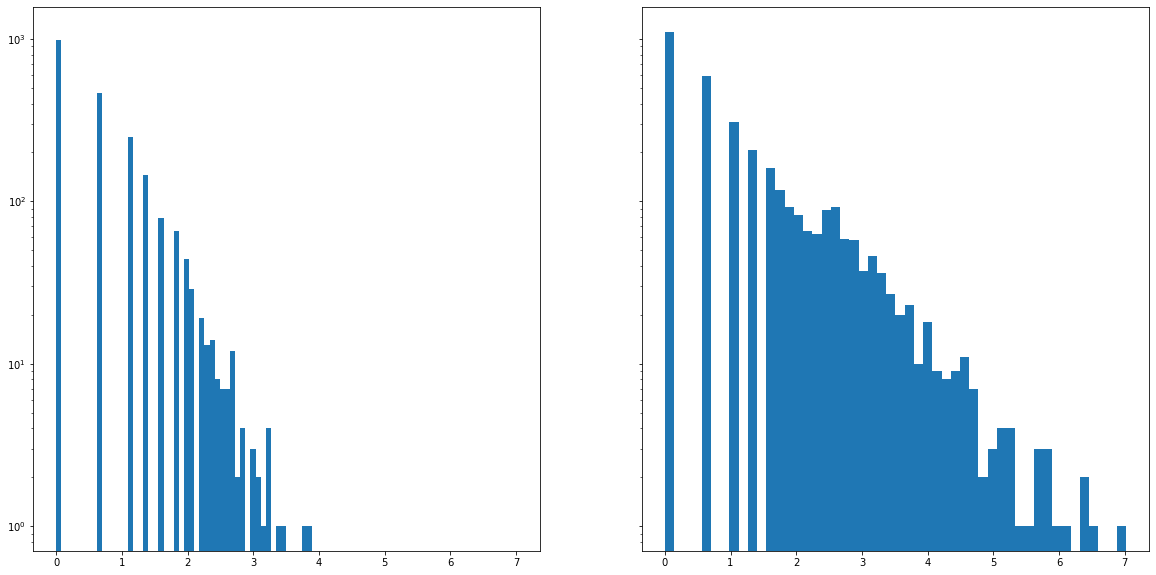

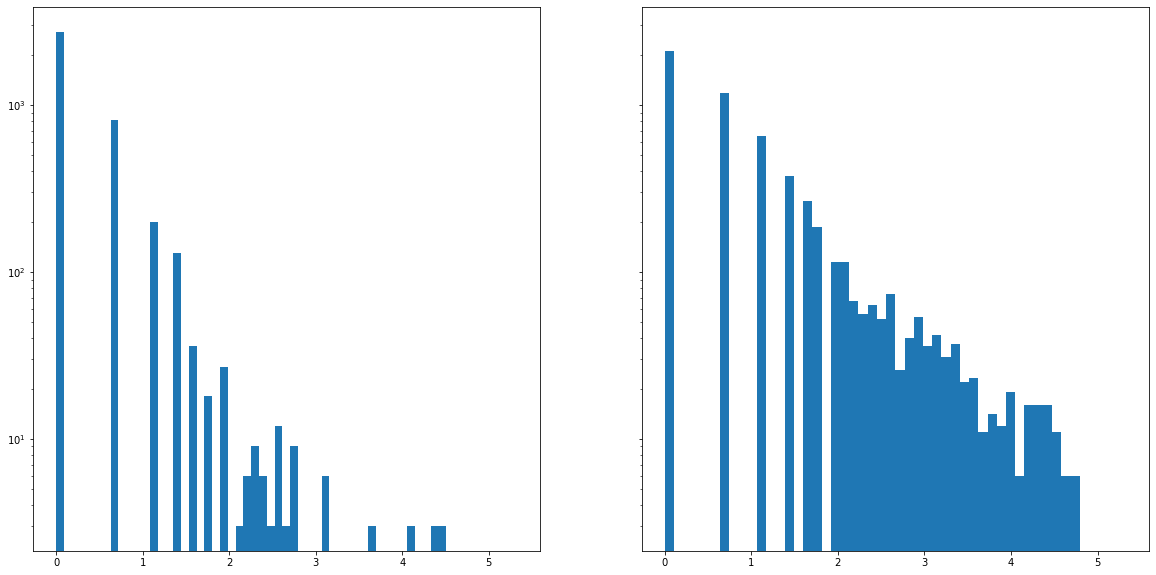

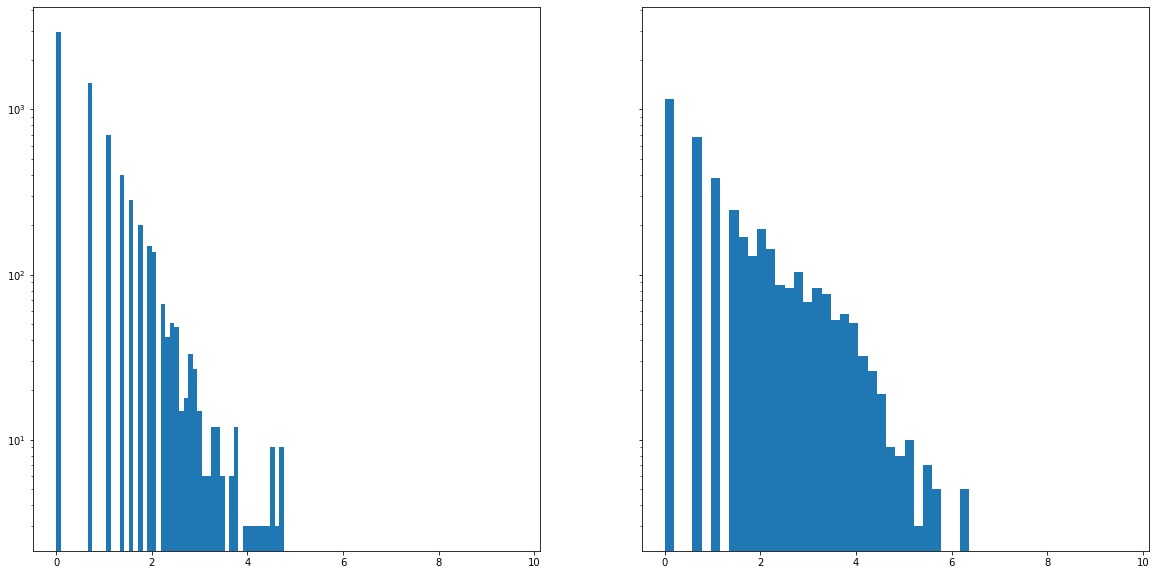

In [173]:
importlib.reload(cs)
for s in range(len(Sub)):
    bl = Sub[s]['bin_base']
    sz = Sub[s]['bin_seiz']

    f, (ax1,ax2) = plt.subplots(1,2,sharey=True, sharex=True, figsize=(20,10))
    ax1.hist(np.log(cs.avcount(bl, AS)), log=True, bins=50)
    ax2.hist(np.log(cs.avcount(sz, AS)), log=True, bins=50)
    f.show()

Calculating best minimal value for power law fit
/Users/roschkoenig/anaconda3/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
/Users/roschkoenig/Dropbox/Research/1812 Critical Dynamics Epilepsy/07 - SEEG/cde_seeg_functions.py:146: RuntimeWarning: divide by zero encountered in log
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value fo

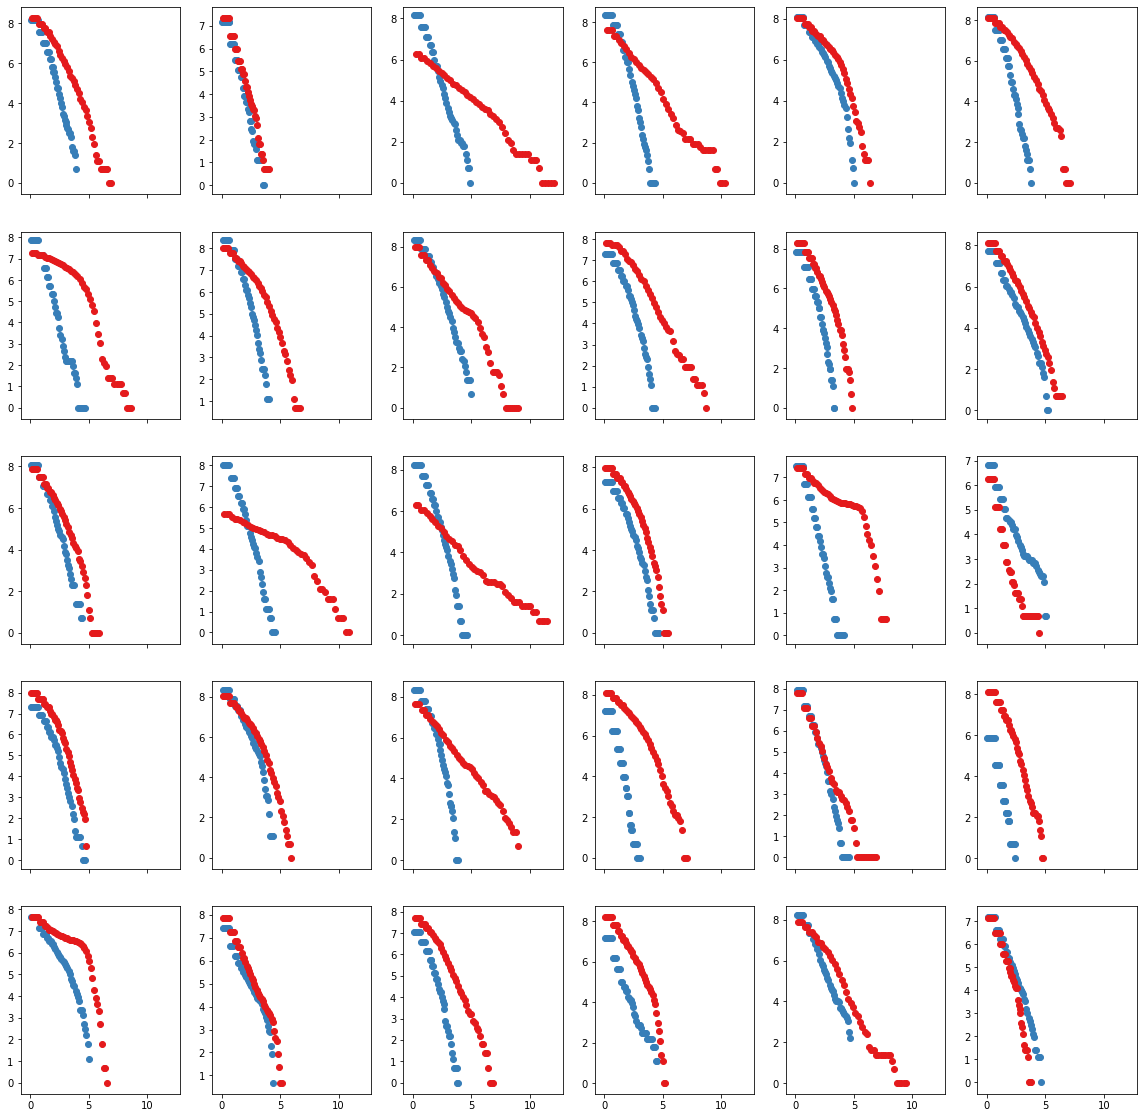

In [179]:
temp = np.zeros((len(Sub),2))
f,ax = plt.subplots(5,6, figsize=(20,20), sharex = True)

for s in range(len(Sub)):
    bl = Sub[s]['bin_base']
    sz = Sub[s]['bin_seiz']
    i  = (np.floor(s/6).astype('int'), np.mod(s,6)-1)
    
    avc        = cs.avcount(bl, AS)
    results    = pl.Fit(avc)
    R_bl,p_bl  = results.distribution_compare('power_law', 'lognormal_positive')
    al_bl      = results.alpha
    cs.plot_ccdf(avc, color=1, No_bins=50,ax=ax[i])
    
    avc        = cs.avcount(sz, AS)
    results    = pl.Fit(avc)
    R_sz,p_sz  = results.distribution_compare('power_law', 'lognormal_positive')
    al_sz      = results.alpha
    cs.plot_ccdf(avc, color=0, No_bins=50,ax=ax[i])

    Sub[s].update({'base_llh': (R_bl, p_bl), 'seiz_llh': (R_sz, p_sz), 'base_alpha':al_bl, 'seiz_alpha':al_sz})
    temp[s,:] = (al_bl, al_sz)
    
#    print('This is a power law', end =' ') if R >= 0 else print('This is rubbish', end = ' '),
#    print(', I''m sure') if p<0.05 else print(', maybe?') 

3.420638830230877
3.1709545316925345


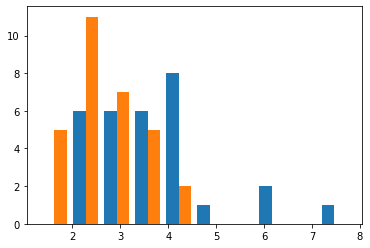

In [185]:
plt.hist(temp)
print(np.mean(temp[0,:]))
print(np.mean(temp[1,:]))
